In [24]:
import io
import fitz
import re
from PIL import Image, ImageDraw, ImageFont, ImageColor
import operator
import os
import pandas as pd 
import numpy as np
from datetime import datetime
import math
from tqdm import tqdm

from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

In [25]:
"""INDEX 1"""
pdf_dir = "../input/NOUVELLE FLORE DU LIBAN ET DE LA SYRIE 1.pdf"
doc = fitz.open(pdf_dir)
pages = [doc[i] for i in range(doc.page_count)]
"""INDEX 1"""

TARGET_DPI = 300
mat = fitz.Matrix(TARGET_DPI/ 72, TARGET_DPI/ 72)

indent_groups = []
indent_err = 15

In [42]:
page_num = 100
pix_map = doc.get_page_pixmap(page_num,matrix=mat)
image = Image.open(io.BytesIO(pix_map.tobytes()))
draw = ImageDraw.Draw(image)
image;

In [43]:
block_lst = pages[page_num].get_text("dict")['blocks']
block_lst;

In [60]:
blank_im = Image.new('RGB', image.size, (255, 255, 255))
blank_draw = ImageDraw.Draw(blank_im)
dy_block_lst = []
x0, y0, x1, y1 = 0, 0, 0, 0
myFont = ImageFont.truetype("Arial", 15)
g_i = 0
#block_lst = dict(block_lst)
for b in block_lst:
    if b['type'] == 0:
        prev_x0, prev_y0, prev_x1, prev_y1 = x0, y0, x1, y1
        x0, y0, x1, y1 = [coord*TARGET_DPI/ 72 for coord in b['bbox']]
        #print(y0, prev_y1)
        w = 1 
        if x0 > 300 and x1 < 1400: 
            w = 5
        draw.rectangle((x0, y0, x1, y1), fill=None, outline=ImageColor.getrgb("#222222"), width = w)
        dy = y0 - prev_y1
        dy_block_lst.append(dy)
        blank_draw.rectangle((x0, y0, x1, y1), fill=None, outline=ImageColor.getrgb("#222222"), width = w)
        blank_draw.text((20, prev_y1), str(dy), font=myFont, fill =(255, 0, 0))
        draw.text((20, prev_y1), str(dy), font=myFont, fill =(255, 0, 0))
        
        b['block_group'] = g_i
        if prev_y1 == 0 or dy > 15:
            g_i += 1

        blank_draw.text((prev_x1, prev_y1), str(b['block_group']), font=myFont, fill =(0, 0, 255))
        draw.text((prev_x1, prev_y1), str(b['block_group']), font=myFont, fill =(0, 0, 255))
        

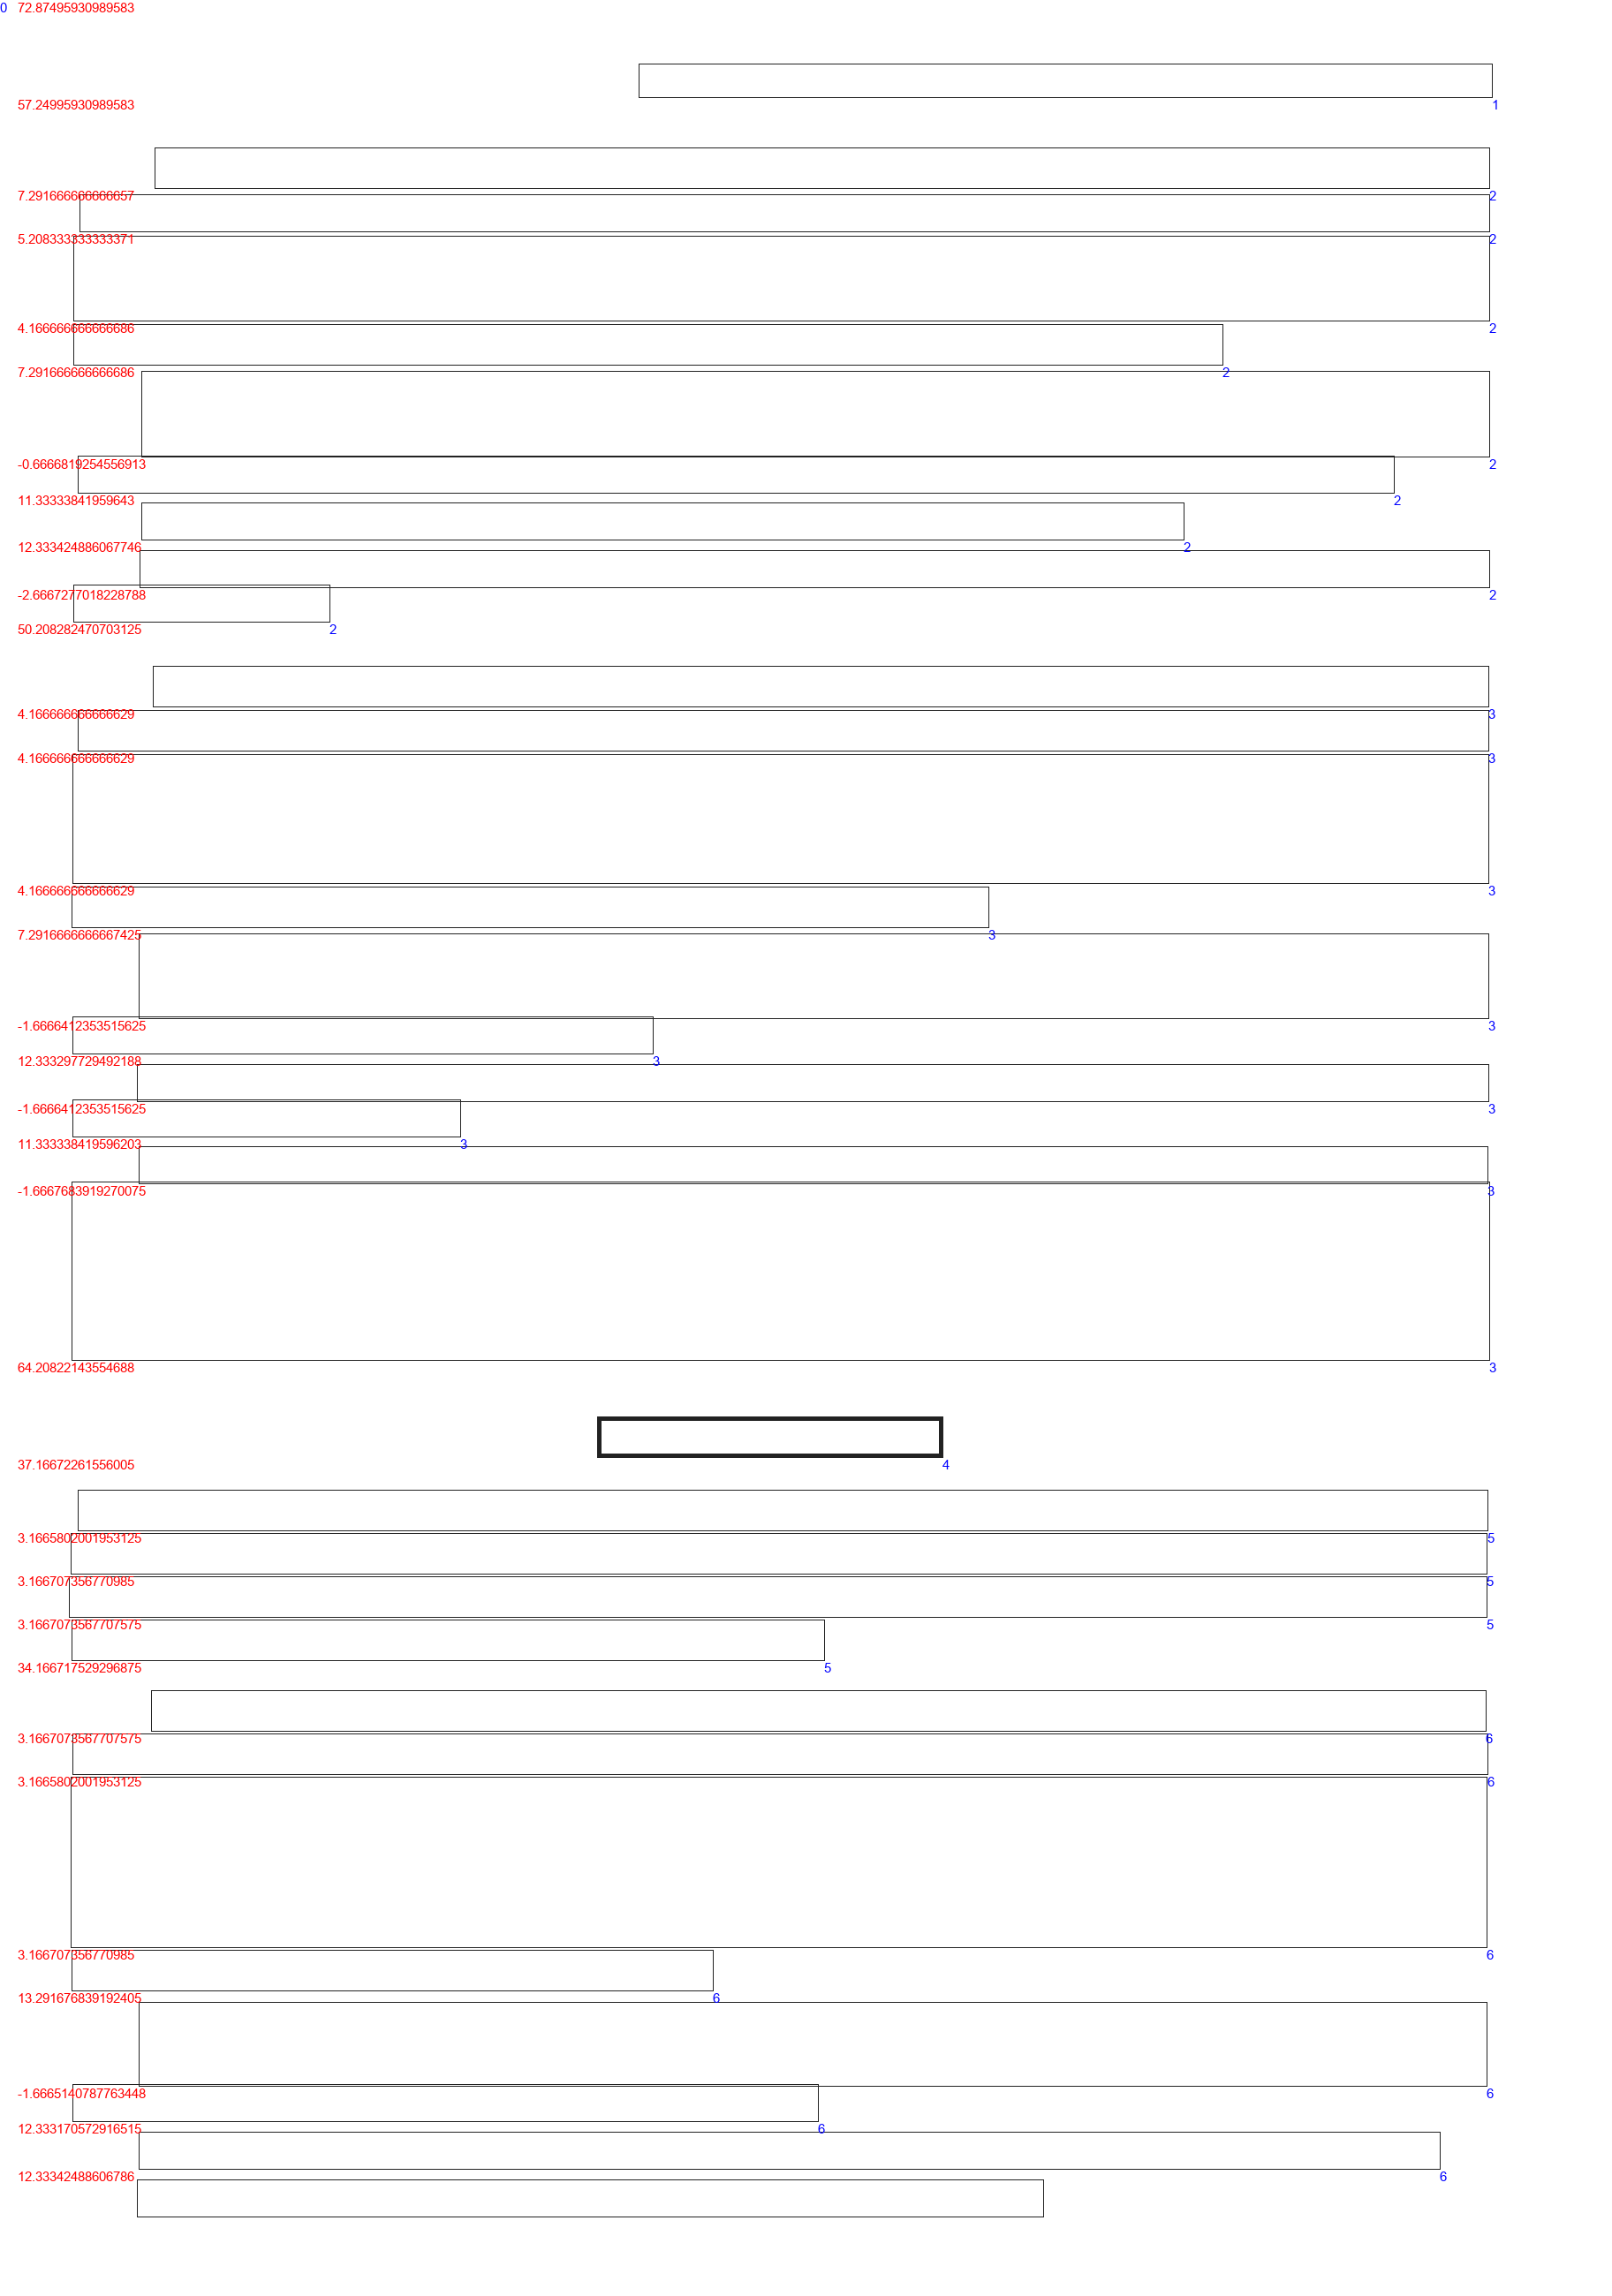

In [61]:
blank_im

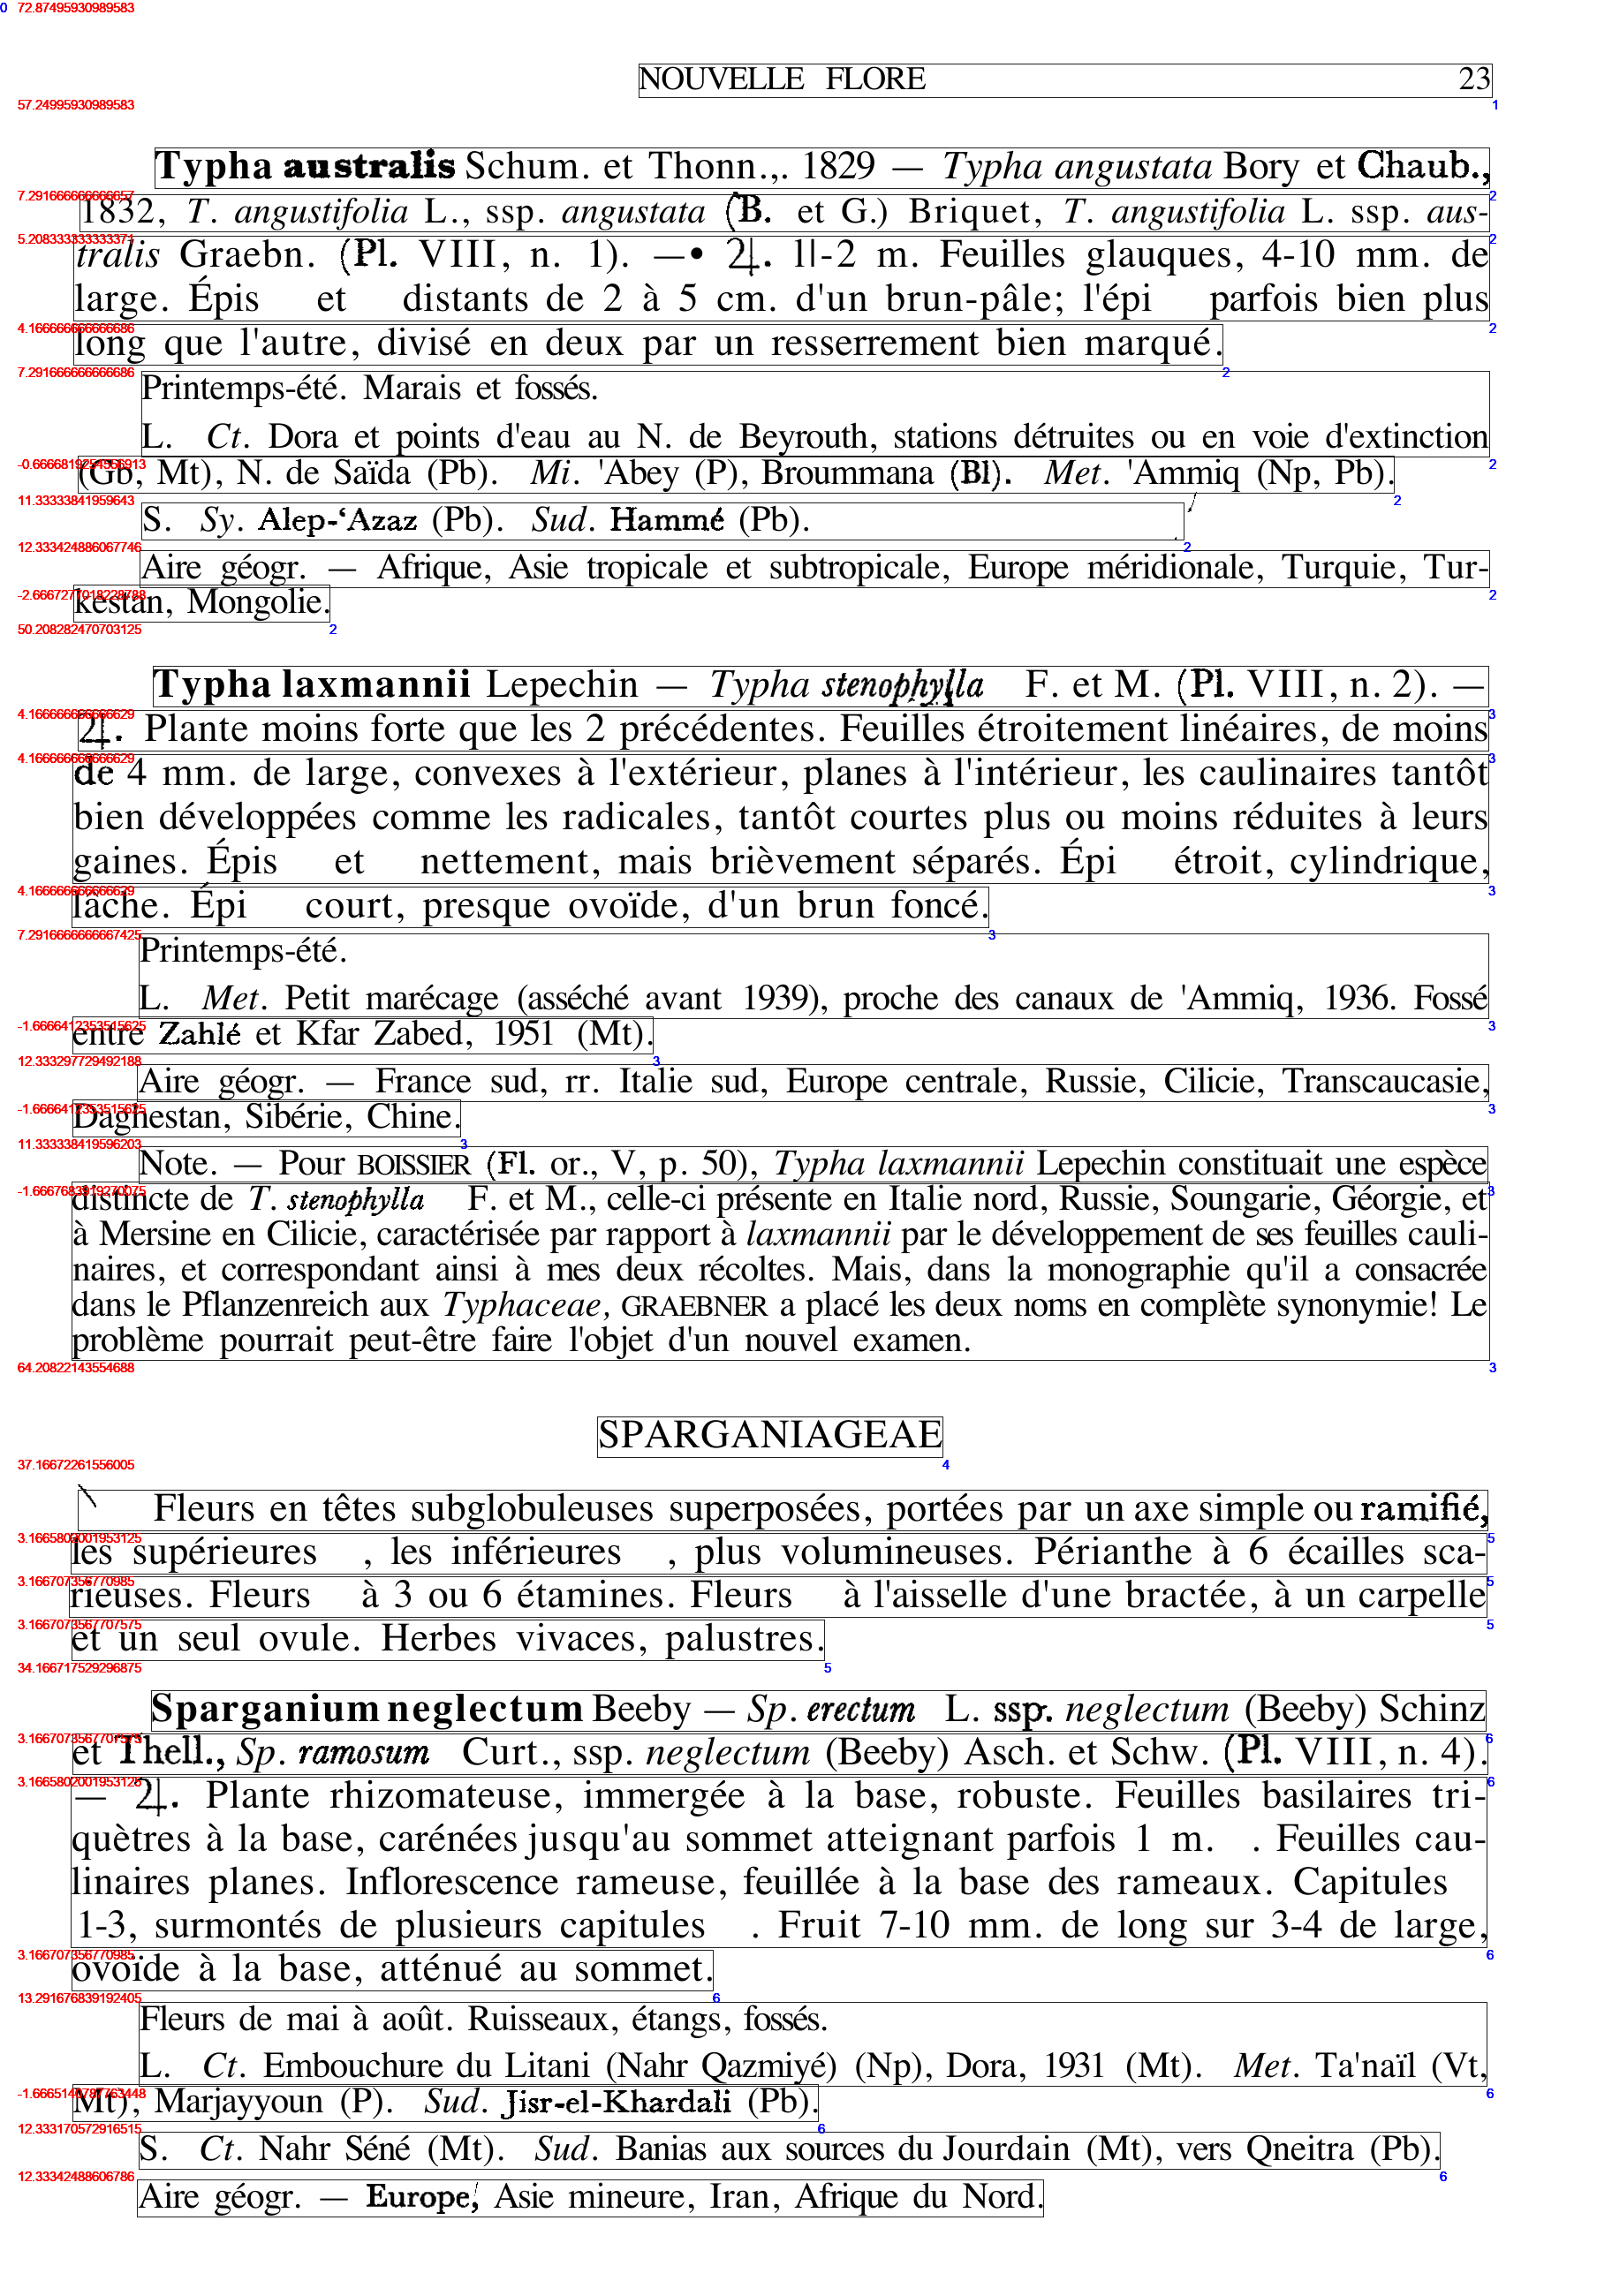

In [57]:
image

In [47]:
colors21 = ['#800000', '#e6194B', '#fabed4', 
            '#9A6324', '#f58231', '#ffd8b1', '#fffac8', '#ffe119',
            '#808000', '#bfef45', '#3cb44b', '#aaffc3', '#469990',
            '#42d4f4', '#4363d8', '#000075',
            '#911eb4', '#dcbeff', '#f032e6', 
            '#a9a9a9', '#000000']

colors7 = ['#ff0000', '#ffa500', '#ffff00', '#008000', '#0000ff', '#4b0082', '#ee82ee']

In [62]:
pix_map = doc.get_page_pixmap(page_num,matrix=mat)
image = Image.open(io.BytesIO(pix_map.tobytes()))
blank_im = Image.new('RGB', image.size, (255, 255, 255))
blank_draw = ImageDraw.Draw(blank_im)
draw = ImageDraw.Draw(image)
myFont = ImageFont.truetype("Arial", 15)

def group_blocks(block_lst, dy_threshold):
    x0, y0, x1, y1 = 0, 0, 0, 0
    g_i = -1 #just because we will definitly add 1 to g_1 as prev_y1 will start at 0 first
    for b in block_lst:
        if b['type'] == 0:
            prev_x0, prev_y0, prev_x1, prev_y1 = x0, y0, x1, y1
            x0, y0, x1, y1 = [coord*TARGET_DPI/ 72 for coord in b['bbox']]
            #print(y0, prev_y1)
            #draw.rectangle((x0, y0, x1, y1), fill=None, outline=ImageColor.getrgb("#222222"), width = 1)
            dy = y0 - prev_y1
            #dy_block_lst.append(dy)
            #blank_draw.rectangle((x0, y0, x1, y1), fill=None, outline=ImageColor.getrgb("#222222"), width = 1)
            #blank_draw.text((20, prev_y1), str(dy), font=myFont, fill =(255, 0, 0))
            #draw.text((20, prev_y1), str(dy), font=myFont, fill =(255, 0, 0))
        
            if prev_y1 == 0 or dy > dy_threshold:
                g_i += 1

            b['block_group'] = g_i

            #blank_draw.text((prev_x1, prev_y1), str(b['block_group']), font=myFont, fill =(0, 0, 255))
            #draw.text((prev_x1, prev_y1), str(b['block_group']), font=myFont, fill =(0, 0, 255))

def draw_groups(draw, color_lst = colors7):
    block_no = -1
    color = color_lst[0]
    for b in block_lst:
        if b['type'] == 0:
            block_no, prev_block_no = b['block_group'], block_no
            if block_no != 0 and block_no != prev_block_no:
                #color = color_lst[block_no%len(color_lst)]
                group_x0, group_y0, group_x1, group_y1 = min(x0_lst), min(y0_lst), max(x1_lst),  max(y1_lst)
                w = 1 
                if group_x0 > 300 and group_x1 < 1400: 
                    w = 5
                draw.rectangle((group_x0, group_y0, group_x1, group_y1), fill=None, outline=ImageColor.getrgb(color), width = w)
            if block_no != prev_block_no: 
                x0_lst, y0_lst, x1_lst, y1_lst = [], [], [], []
            
            prev_block_no = block_no
            x0, y0, x1, y1 = [coord*TARGET_DPI/ 72 for coord in b['bbox']]
            x0_lst.append(x0)
            y0_lst.append(y0)
            x1_lst.append(x1)
            y1_lst.append(y1)
    #draw last one
    #color = color_lst[block_no%len(color_lst)]
    group_x0, group_y0, group_x1, group_y1 = min(x0_lst), min(y0_lst), max(x1_lst),  max(y1_lst)
    draw.rectangle((group_x0, group_y0, group_x1, group_y1), fill=None, outline=ImageColor.getrgb(color), width = 2)


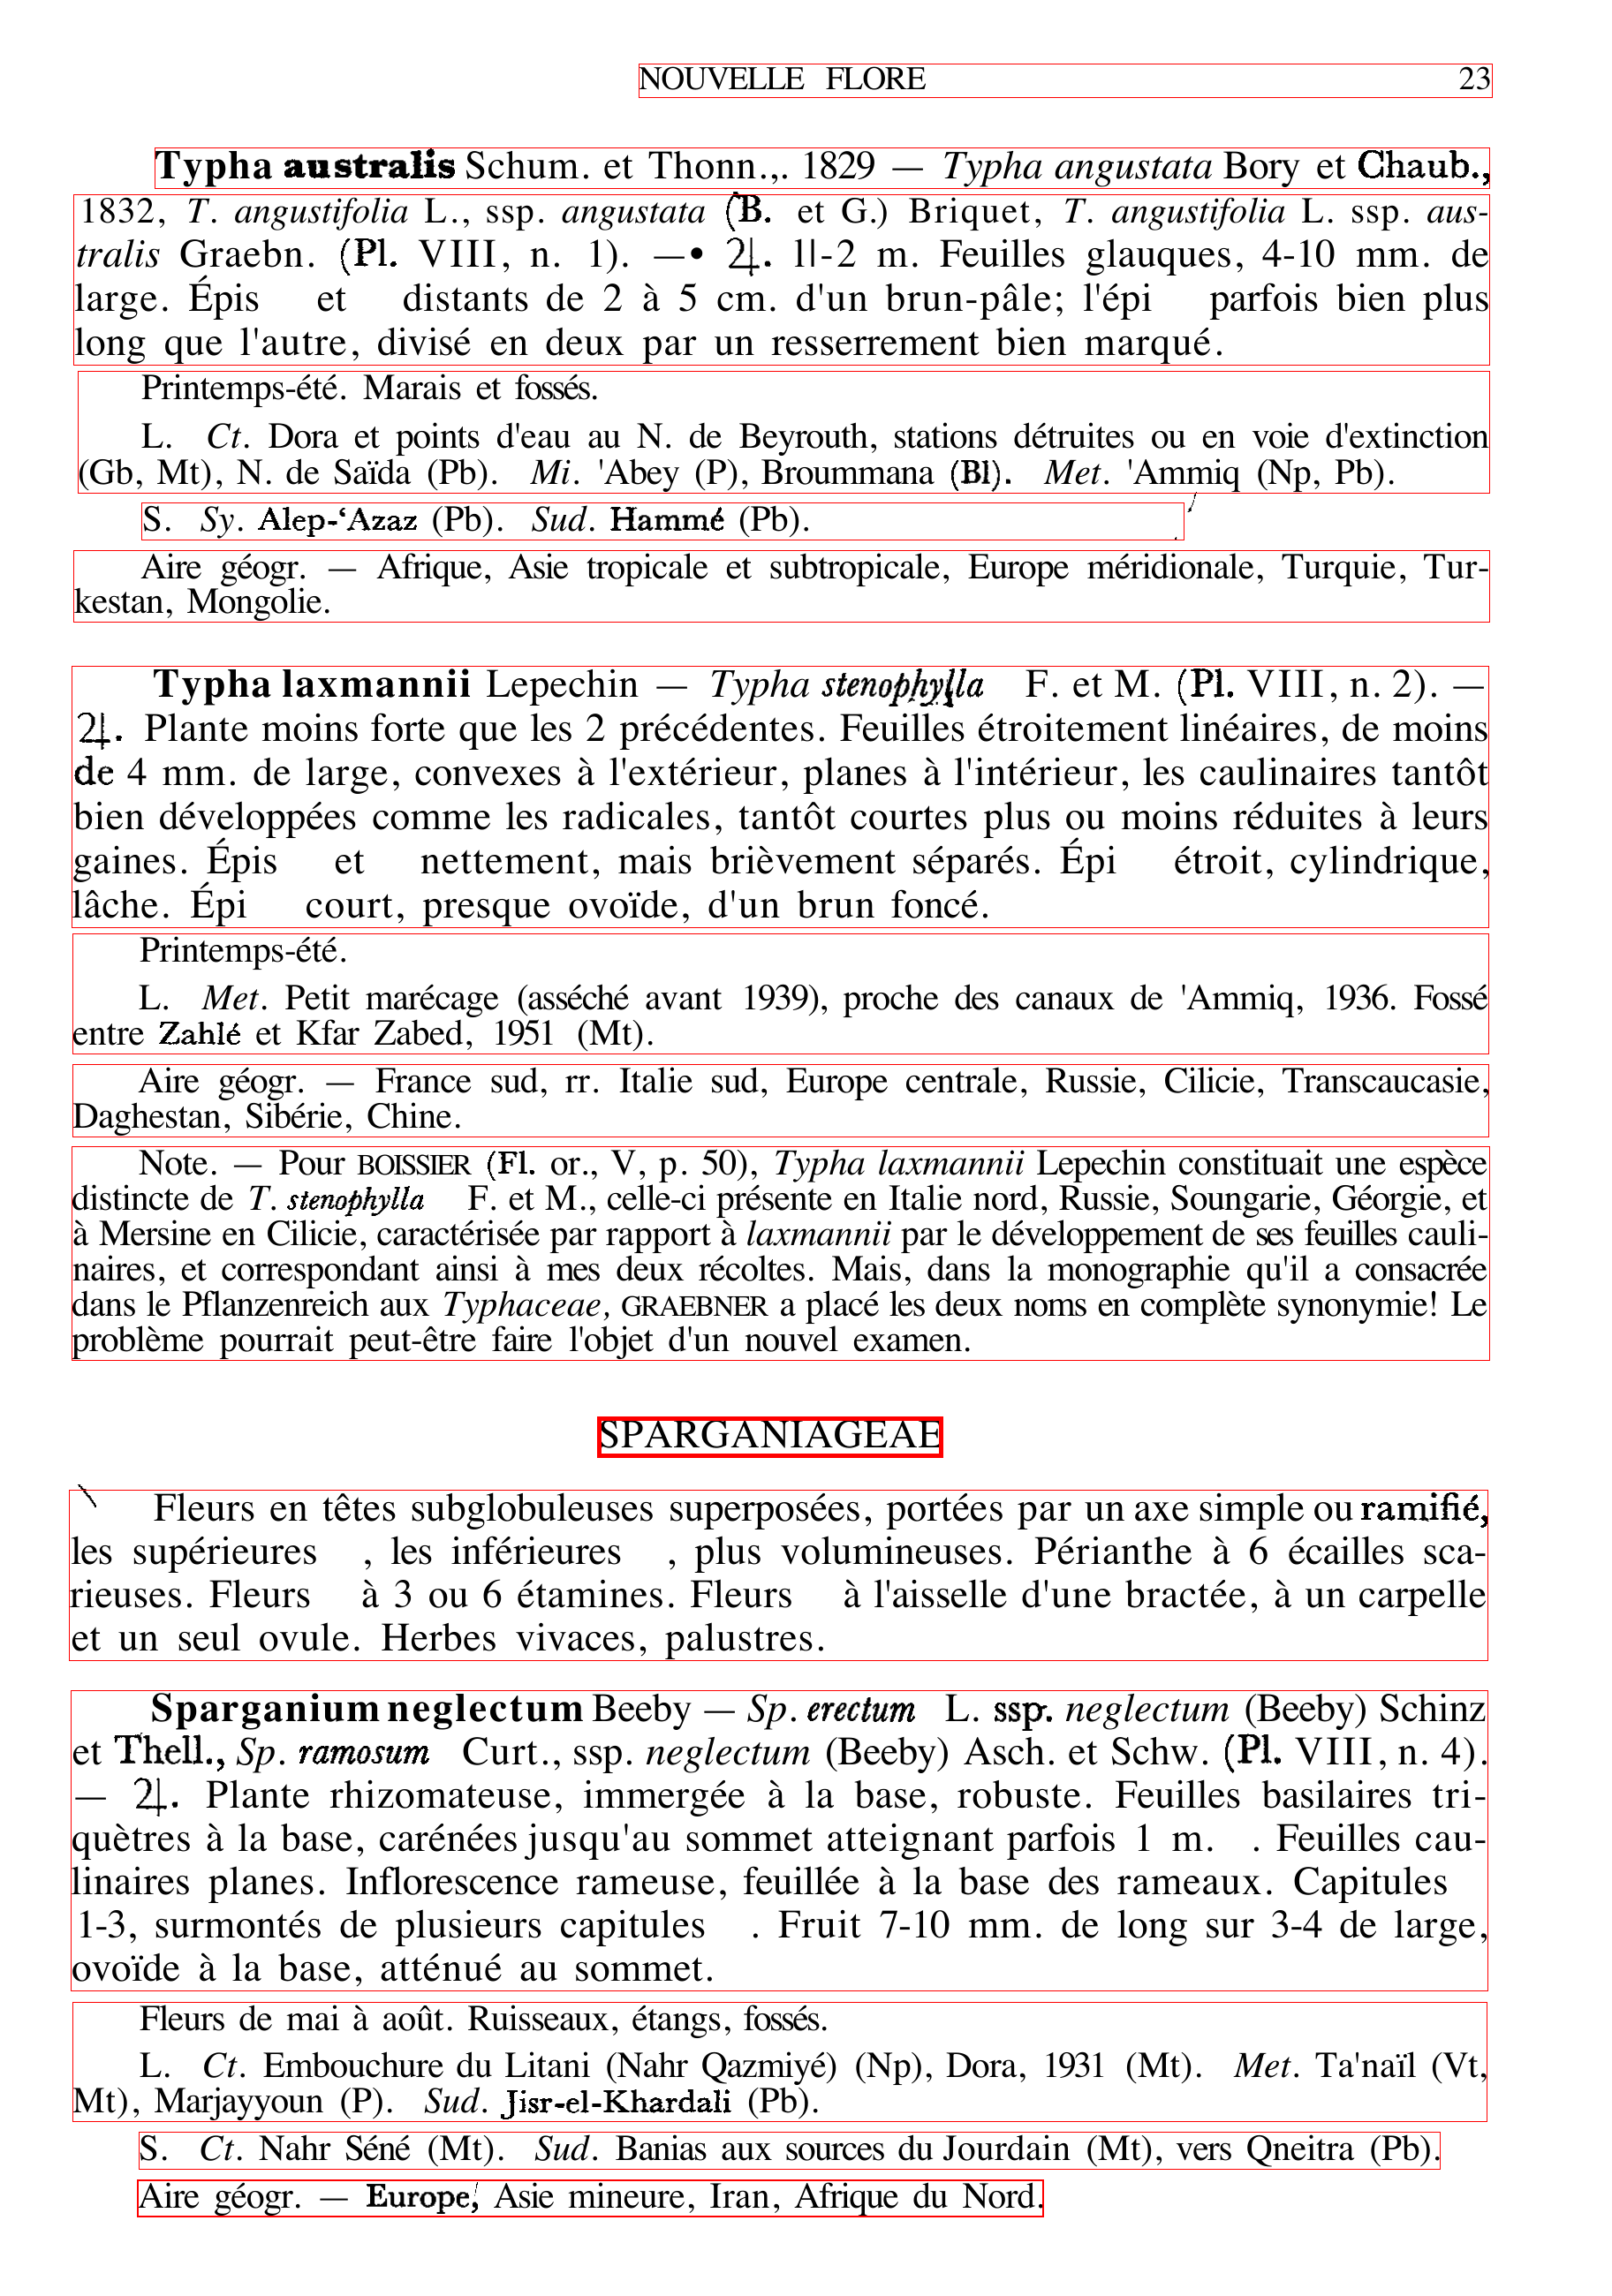

In [63]:
myFont = ImageFont.truetype("Arial", 15)

page_num = 100
block_lst = pages[page_num].get_text("dict")['blocks']
group_blocks(block_lst, 7)

pix_map = doc.get_page_pixmap(page_num,matrix=mat)
image = Image.open(io.BytesIO(pix_map.tobytes()))
draw = ImageDraw.Draw(image)
draw_groups(draw)
image

# YAY

In [34]:
#Setting up files and directories for saving the results
SCRIPT_NAME = "block_grouping"
SCRIPT_OUTPUT_PATH = "../output/main_text/" + SCRIPT_NAME + "/" 
DATE_STR = datetime.now().strftime("%Y_%m_%d") 
TIME_STR = datetime.now().strftime("%H%M")
QUICK_FIX = False
TAIL_STR = ''

if QUICK_FIX:
    OUTPUT_PATH = SCRIPT_OUTPUT_PATH + DATE_STR + "/QuickFix/" 
    #TAIL_STR = '_' + DATE_STR + '_' + TIME_STR
else:
    OUTPUT_PATH = SCRIPT_OUTPUT_PATH + DATE_STR + "/" + TIME_STR + "/"

try:
    os.makedirs(OUTPUT_PATH)
except FileExistsError:
    # directory already exists
    pass

In [36]:
result_ims = []

myFont = ImageFont.truetype("Arial", 15)

for page_num in tqdm(range(2*doc.page_count//4, 3*doc.page_count//4)):
    block_lst = pages[page_num].get_text("dict")['blocks']
    group_blocks(block_lst, 8)
    pix_map = doc.get_page_pixmap(page_num,matrix=mat)
    image = Image.open(io.BytesIO(pix_map.tobytes()))
    draw = ImageDraw.Draw(image)
    draw_groups(draw)
    result_ims.append(image)

result_ims[0].save(OUTPUT_PATH + 'colored_blocks_3rdquarter.pdf',save_all=True, append_images=result_ims[1:])

100%|██████████| 160/160 [00:31<00:00,  5.15it/s]
